# **Sistem Rekomendasi Ekowisata di Indonesia – Imelda Cyntia**

## Ringkasan

Proyek ini bertujuan untuk membangun sistem rekomendasi ekowisata di Indonesia yang mampu memberikan saran destinasi secara personal dan relevan kepada pengguna. Sistem dikembangkan dengan menggunakan dua pendekatan, yaitu Content-Based Filtering dan Collaborative Filtering.

Dengan adanya sistem ini, diharapkan promosi destinasi wisata berbasis alam dan budaya lokal dapat lebih tersebar merata dan tepat sasaran, khususnya ke tempat-tempat yang selama ini kurang terekspos di platform digital.

## Sumber Dataset

Dataset yang digunakan berasal dari Kaggle:
 [Dataset *Indonesia’s Ecotourism* – Kaggle](https://www.kaggle.com/datasets/rizkysetiawann/indonesias-ecotourism-dataset)

Dataset terdiri dari tiga bagian utama, yaitu:

1. eco\_place.csv
   Berisi data detail mengenai tempat ekowisata, termasuk nama tempat, deskripsi, kategori wisata, lokasi (kota dan provinsi), harga tiket, rating, serta koordinat geografis.

2. eco\_event.csv
   Menyediakan informasi mengenai acara atau kegiatan yang pernah diselenggarakan di destinasi tersebut. Data ini berguna untuk memperkaya rekomendasi berdasarkan aktivitas yang mungkin diminati pengguna.

3. eco\_rating.csv
   Berisi data penilaian atau rating yang diberikan pengguna terhadap tempat wisata tertentu. Data ini menjadi dasar untuk penerapan Collaborative Filtering dalam sistem rekomendasi.


# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from tabulate import tabulate

# **Data Understanding**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eco_event.csv to eco_event.csv
Saving eco_place.csv to eco_place.csv
Saving eco_rating.csv to eco_rating.csv


### **Mengubah nama file dataset agar lebih ringkas**

In [ ]:
!mv '/content/eco_place.csv' 'places.csv'
!mv '/content/eco_event.csv' 'events.csv'
!mv '/content/eco_rating.csv' 'ratings.csv'

Pada tahap ini, dilakukan perubahan nama file dataset agar lebih ringkas dan mudah digunakan dalam proses pemanggilan data. Dataset `eco_place.csv`, `eco_event.csv`, dan `eco_rating.csv` masing-masing diubah menjadi `places.csv`, `events.csv`, dan `ratings.csv`.

### **Load ulang dengan nama file baru**

In [ ]:
df_place = pd.read_csv('places.csv')
df_event = pd.read_csv('events.csv')
df_rating = pd.read_csv('ratings.csv')

Setelah perubahan nama, dataset kemudian dimuat ulang ke dalam tiga variabel dataframe utama:
- `df_place` untuk menyimpan informasi tempat ekowisata.
- `df_event` untuk menyimpan data acara atau event terkait ekowisata.
- `df_rating` untuk menyimpan data rating atau ulasan dari pengguna.


### **Memuat dan Menampilkan Informasi Dataset `df_place`**

Pada tahap ini, dilakukan proses eksplorasi awal terhadap dataset `places.csv` yang telah dimuat ke dalam variabel `df_place`. Proses ini mencakup:

1. Menampilkan struktur data menggunakan `info()`

   Untuk mengetahui jumlah data, tipe data setiap kolom, serta apakah terdapat nilai kosong (null) pada kolom tertentu.

2. Melihat lima baris pertama data menggunakan `head()`

   Untuk mendapatkan gambaran isi data secara umum, termasuk nama tempat, deskripsi, kategori, harga, rating, serta link gambar dan lokasi.

3. Pengecekan missing values menggunakan `isnull().sum()`

   Untuk mengetahui apakah ada kolom dengan nilai kosong yang perlu ditangani dalam tahap preprocessing.

In [ ]:
df_place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   place_id              182 non-null    int64  
 1   place_name            182 non-null    object 
 2   place_description     182 non-null    object 
 3   category              182 non-null    object 
 4   city                  182 non-null    object 
 5   price                 182 non-null    object 
 6   rating                182 non-null    float64
 7   description_location  182 non-null    object 
 8   place_img             182 non-null    object 
 9   gallery_photo_img1    182 non-null    object 
 10  gallery_photo_img2    180 non-null    object 
 11  gallery_photo_img3    105 non-null    object 
 12  place_map             182 non-null    object 
dtypes: float64(1), int64(1), object(11)
memory usage: 18.6+ KB


In [ ]:
df_place.head()

,place_id,place_name,place_description,category,city,price,rating,description_location,place_img,gallery_photo_img1,gallery_photo_img2,gallery_photo_img3,place_map
0,1,Taman Nasional Gunung Leuser,Taman Nasional Gunung Leuser adalah salah satu...,"Budaya,Taman Nasional",Aceh,"Rp25,000",4.5,"Barisan mountain range, Aceh 24653",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Taman+Nasio...
1,2,Desa Wisata Munduk,Desa Wisata Munduk adalah sebuah desa di pegun...,Desa Wisata,Bali,"Rp10,000",4.5,"Munduk, Banjar, Kabupaten Buleleng, Bali",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://goo.gl/maps/LyeJ2mAeFGysTE9v9
2,3,Desa Wisata Penglipuran,Desa Wisata Penglipuran adalah sebuah desa wis...,"Budaya,Desa Wisata",Bali,"Rp25,000",4.8,"Jl. Penglipuran, Kubu, Kec. Bangli, Kabupaten ...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Desa+Wisata...
3,4,Taman Nasional Bali Barat,Taman Nasional Bali Barat adalah kawasan konse...,"Taman Nasional,Cagar Alam",Bali,"Rp15,000",4.5,"Sumber Klampok, Bali",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Taman+Nasio...
4,5,Bukit Jamur,Bukit Jamur Ciwidey adalah satu dari sekian ba...,Cagar Alam,Bandung,"Rp12,000",4.2,"Sugihmukti, Kec. Pasirjambu, Kabupaten Bandung...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Bukit+Jamur


In [ ]:
print(df_place.isnull().sum())

place_id                 0
place_name               0
place_description        0
category                 0
city                     0
price                    0
rating                   0
description_location     0
place_img                0
gallery_photo_img1       0
gallery_photo_img2       2
gallery_photo_img3      77
place_map                0
dtype: int64


**Insight:**

* Dataset terdiri dari 182 entri dan 13 fitur.
* Kolom `gallery_photo_img2` memiliki 2 nilai kosong, sedangkan `gallery_photo_img3` memiliki 77 nilai kosong.
* Kolom-kolom lainnya tidak memiliki missing values, sehingga sebagian besar data cukup lengkap.
* Tipe data masih perlu perhatian lebih lanjut, terutama kolom `price` yang saat ini masih berupa objek (teks) dan mengandung simbol "Rp".

### **Memuat dan Menampilkan Informasi Dataset `df_event`**

Pada tahap ini, dilakukan proses eksplorasi awal terhadap dataset `events.csv` yang telah dimuat ke dalam variabel `df_event`. Proses ini mencakup:

1. Menampilkan struktur data menggunakan `info()`

   Untuk mengetahui jumlah entri (baris data), tipe data tiap kolom, serta memastikan tidak terdapat nilai kosong (null) yang perlu dibersihkan sebelum diproses lebih lanjut.

2. Melihat lima baris pertama data menggunakan `head()`

   Untuk mendapatkan gambaran awal mengenai isi dataset, termasuk nama event, lokasi penyelenggaraan, tanggal pelaksanaan, serta deskripsi acara yang dapat dimanfaatkan untuk informasi pendukung pada sistem rekomendasi.

3. Pengecekan missing values menggunakan `isnull().sum()`

   Untuk memastikan bahwa tidak ada nilai kosong pada kolom manapun. Hasil menunjukkan bahwa seluruh kolom terisi lengkap, sehingga tidak diperlukan penanganan missing value pada dataset ini.


In [ ]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   event_id     6 non-null      int64 
 1   event_img    6 non-null      object
 2   event_name   6 non-null      object
 3   event_place  6 non-null      object
 4   event_date   6 non-null      object
 5   event_about  6 non-null      object
dtypes: int64(1), object(5)
memory usage: 420.0+ bytes


In [ ]:
df_event.head()

,event_id,event_img,event_name,event_place,event_date,event_about
0,1,https://storage.googleapis.com/travelee-capsto...,FESTIVAL ECOTOURISM 2022 - Membangun Investasi...,"Manokwari City Mall (MCM), Papua Barat",29 September - 1 Oktober 2022,Ayo bergabung dalam FESTIVAL ECOTOURISM 2022 R...
1,2,https://storage.googleapis.com/travelee-capsto...,Festival Taman nasional Taman Wisata Alam Indo...,"Lapangan Aldiron, Jl. Gatot Subroto, Jakarta",5 - 7 Agustus 2022,Sambut Festival FTNTWA dan Festival Ekowisata ...
2,3,https://storage.googleapis.com/travelee-capsto...,Medan - Belawan Mangrove Forest Festival,"Mako Lantamal-I, Medan, Sumatra Utara",19 Agustus 2018,Sambut keindahan hutan mangrove di Medan - Bel...
3,4,https://storage.googleapis.com/travelee-capsto...,FESTIVAL MANGROVE 2022,"Kuala Langsa, Aceh",10 Desember 2022,Selamat datang di Festival Mangrove 2022. Raya...
4,5,https://storage.googleapis.com/travelee-capsto...,INDOFEST INDONESIA OUTDOOR FESTIVAL 2023,"Istora Senayan, Jakarta Selatan",1 - 4 Juni 2023,Selamat datang di Indofest Indonesia Outdoor F...


In [ ]:
print(df_event.isnull().sum())

event_id       0
event_img      0
event_name     0
event_place    0
event_date     0
event_about    0
dtype: int64


**Insight:**

* Total baris data: 6
* Total kolom fitur: 6
* Terdapat 1 kolom bertipe numerik: `event_id`
* Terdapat 5 kolom bertipe object: `event_img`, `event_name`, `event_place`, `event_date`, `event_about`
* Tidak ditemukan missing value di seluruh kolom


### **Memuat dan Menampilkan Informasi Dataset `df_rating`**

Pada tahap ini, dilakukan proses eksplorasi awal terhadap dataset `ratings.csv` yang telah dimuat ke dalam variabel `df_rating`. Proses ini mencakup:

1. Menampilkan struktur data menggunakan `info()`

   Untuk mengetahui jumlah entri (baris data), tipe data tiap kolom, serta memastikan bahwa seluruh data memiliki nilai yang valid.

2. Melihat lima baris pertama data menggunakan `head()`

   Untuk mendapatkan gambaran awal mengenai interaksi pengguna terhadap tempat wisata. Setiap baris menunjukkan satu interaksi berupa rating dari seorang pengguna (`user_id`) terhadap tempat tertentu (`place_id`) dengan nilai rating (`user_rating`).

3. Pengecekan missing values menggunakan `isnull().sum()`

   Untuk memastikan bahwa tidak ada nilai kosong pada kolom manapun.


In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      849 non-null    int64
 1   place_id     849 non-null    int64
 2   user_rating  849 non-null    int64
dtypes: int64(3)
memory usage: 20.0 KB


In [ ]:
df_rating.head()

,user_id,place_id,user_rating
0,1,28,2
1,1,86,4
2,1,94,4
3,1,146,3
4,2,17,2


In [ ]:
print(df_rating.isnull().sum())

user_id        0
place_id       0
user_rating    0
dtype: int64


**Insight:**

* Total baris data: 849
* Total kolom fitur: 3
* Seluruh kolom (user_id, place_id, user_rating) bertipe numerik (int64)
* Tidak ditemukan missing value


# **Exploratory Data Analysis**

##### 1. Place:
Berisi informasi detail tentang tempat-tempat wisata berbasis ekowisata di Indonesia.

* `place_id`: ID unik untuk setiap destinasi wisata.
* `place_name`: Nama dari destinasi wisata.
* `place_description`: Deskripsi mengenai tempat wisata.
* `category`: Kategori wisata (misal: alam, sejarah, edukasi, budaya, dll).
* `city`: Lokasi kota/kabupaten tempat wisata berada.
* `price`: Harga tiket masuk (biasanya dalam format string, perlu preprocessing).
* `rating`: Nilai rata-rata penilaian pengguna (skala 1–5).
* `description_location`: Deskripsi lokasi tempat wisata.
* `place_img`: URL gambar utama dari destinasi.
* `gallery_photo_img1`: URL foto galeri 1.
* `gallery_photo_img2`: URL foto galeri 2 (memiliki 2 missing value).
* `gallery_photo_img3`: URL foto galeri 3 (memiliki 77 missing value).
* `place_map`: URL peta lokasi dari destinasi wisata.

##### 2. Event:
Berisi event atau acara yang berkaitan dengan destinasi ekowisata.

* `event_id`: ID unik untuk setiap event.
* `event_img`: URL gambar promosi event.
* `event_name`: Nama event yang diselenggarakan.
* `event_place`: Lokasi destinasi tempat event berlangsung.
* `event_date`: Tanggal pelaksanaan event.
* `event_about`: Deskripsi atau rincian tentang event.

##### 3. Rating:

Berisi penilaian pengguna terhadap destinasi wisata tertentu.

* `user_id`: ID unik pengguna.
* `place_id`: ID destinasi wisata yang dinilai (mengacu ke `eco_place.csv`).
* `user_rating`: Rating yang diberikan pengguna terhadap destinasi (skala 1–5).



###  **1. Eksplorasi Awal Tempat Wisata**

#### **Menampilkan 1 baris pertama dari tempat wisata**
Untuk memahami struktur dataset, berikut ditampilkan satu baris pertama dari df_place.

In [ ]:
df_place.head(1)

,place_id,place_name,place_description,category,city,price,rating,description_location,place_img,gallery_photo_img1,gallery_photo_img2,gallery_photo_img3,place_map
0,1,Taman Nasional Gunung Leuser,Taman Nasional Gunung Leuser adalah salah satu...,"Budaya,Taman Nasional",Aceh,"Rp25,000",4.5,"Barisan mountain range, Aceh 24653",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Taman+Nasio...


**Insight:**

Dari baris pertema terlihat bahwa setiap baris mewakili satu destinasi wisata yang memiliki informasi seperti nama tempat, deskripsi, kategori, kota, harga, rating, lokasi, tautan gambar, dan tautan Google Maps.


#### **Menampilkan Jumlah Tempat Wisata Unik dan Daftar Tempat Wisata**

Pada tahap ini, dilakukan dua proses:

1. Menghitung jumlah tempat wisata unik berdasarkan kolom `place_name`. Proses ini berguna untuk mengetahui berapa banyak destinasi wisata yang berbeda dalam dataset.
2. Menyusun tabel yang berisi pasangan unik antara `place_id` dan `place_name`, lalu menampilkannya dalam bentuk tabel yang bersih tanpa index.

Hasil dari proses ini akan membantu memahami sebaran tempat wisata dalam dataset.


In [ ]:
jumlah_tempat_unik = df_place['place_name'].nunique()
print(f"Jumlah Tempat Wisata Unik: {jumlah_tempat_unik}")

tabel_tempat_wisata = (
    df_place[['place_id', 'place_name']]
    .drop_duplicates()
    .sort_values(by='place_id')
    .reset_index(drop=True)
)

print(tabel_tempat_wisata.to_string(index=False))

Jumlah Tempat Wisata Unik: 182
 place_id                                       place_name
        1                     Taman Nasional Gunung Leuser
        2                               Desa Wisata Munduk
        3                          Desa Wisata Penglipuran
        4                        Taman Nasional Bali Barat
        5                                      Bukit Jamur
        6                                       Bukit Moko
        7                                    Curug Bugbrug
        8                                Curug Cilengkrang
        9                                     Curug Cimahi
       10                                    Curug Cipanas
       11                            Curug Luhur Waterfall
       12                                     Curug Malela
       13                            Curug Tilu Leuwi Opat
       14               Desa Wisata Kampung Cai Ranca Upas
       15                                      Dusun Bambu
       16                

**Insight:**

Dataset ini mencakup 182 tempat wisata unik di Indonesia, yang tersebar di berbagai kategori ekowisata seperti taman nasional, desa wisata, pantai, air terjun, dan situs budaya. Keanekaragaman destinasi ini mencerminkan potensi besar Indonesia dalam pengembangan ekowisata berbasis alam dan budaya lokal.

#### **Visualisasi 10 Tempat Wisata Pertama Berdasarkan Place ID**

Langkah ini menampilkan 10 tempat wisata pertama dari tabel `tabel_tempat_wisata`, kemudian divisualisasikan dalam bentuk bar chart horizontal. Visualisasi ini memberikan gambaran awal mengenai nama-nama destinasi dan nilai `place_id` yang terkait. Pengurutan dilakukan berdasarkan urutan dalam dataset setelah disortir berdasarkan `place_id`.


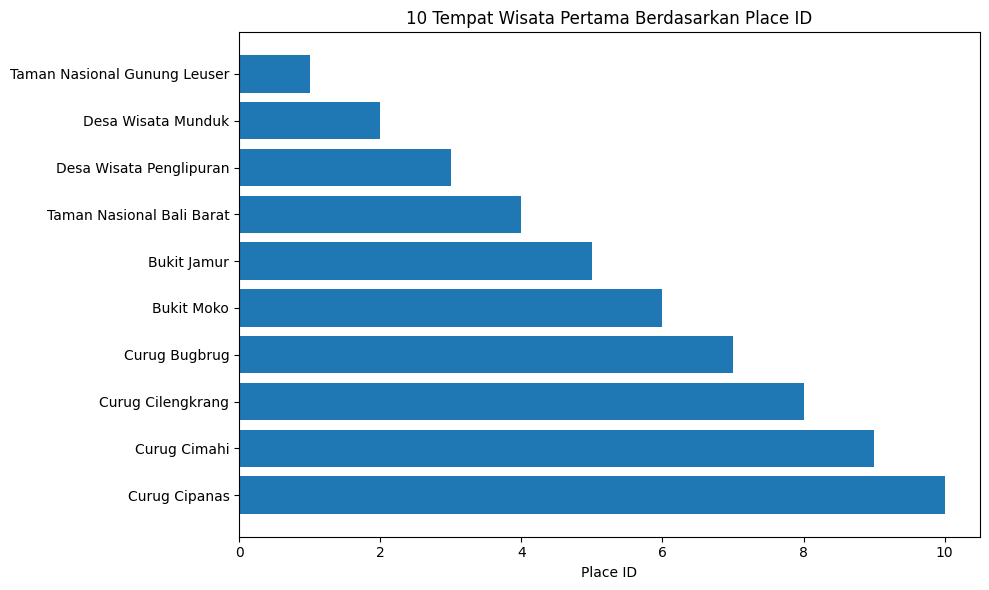

In [ ]:
top_10_tempat = tabel_tempat_wisata.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_tempat['place_name'], top_10_tempat['place_id'])
plt.xlabel('Place ID')
plt.title('10 Tempat Wisata Pertama Berdasarkan Place ID')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Insight:**

Visualisasi ini menampilkan 10 tempat wisata pertama berdasarkan place_id. Urutannya konsisten dengan ID terkecil hingga terbesar, yang mencerminkan urutan input data bukan popularitas atau frekuensi. Ini berguna untuk melihat daftar awal tempat wisata unik dalam dataset.

### **2. Distribusi Kategori Destinasi Wisata**

Pada tahap ini, kategori destinasi wisata yang semula ditulis dalam satu kolom dan dipisahkan dengan koma akan dipecah menjadi kategori individual. Hal ini dilakukan untuk mendapatkan distribusi yang lebih akurat dari setiap jenis kategori wisata.

Setelah pemisahan dilakukan, dihitung frekuensi kemunculan masing-masing kategori di seluruh destinasi yang ada. Hasil distribusi ini memberikan insight tentang jenis kategori wisata yang paling dominan dalam dataset.

In [ ]:
kategori_terpisah = df_place['category'].str.split(',', expand=True).stack().reset_index(drop=True)
kategori_terpisah.name = 'kategori_individual'

frekuensi_kategori = kategori_terpisah.value_counts()

print(f"Jumlah Kategori Individual: {frekuensi_kategori.shape[0]}")
print("\nDistribusi Jumlah Destinasi per Kategori (Terpisah):")
print(frekuensi_kategori)

Jumlah Kategori Individual: 6

Distribusi Jumlah Destinasi per Kategori (Terpisah):
kategori_individual
Cagar Alam        146
Budaya             53
Bahari             34
Taman Nasional     32
Taman Hiburan      31
Desa Wisata        14
Name: count, dtype: int64


**Insight:**

Berdasarkan hasil perhitungan, terdapat 6 kategori wisata unik. Berikut distribusi jumlah destinasi untuk masing-masing kategori:
- Cagar Alam: 146
- Budaya: 53
- Bahari: 34
- Taman Nasional: 32
- Taman Hiburan: 31
- Desa Wisata: 14

#### **Visualisasi Distribusi Kategori Destinasi Wisata**

Setelah kategori destinasi wisata dipisahkan dari kolom `category`, dilakukan perhitungan frekuensi kemunculan setiap kategori. Visualisasi ini bertujuan untuk menunjukkan persebaran jumlah destinasi berdasarkan kategori individual, sehingga dapat terlihat kategori mana yang paling dominan.


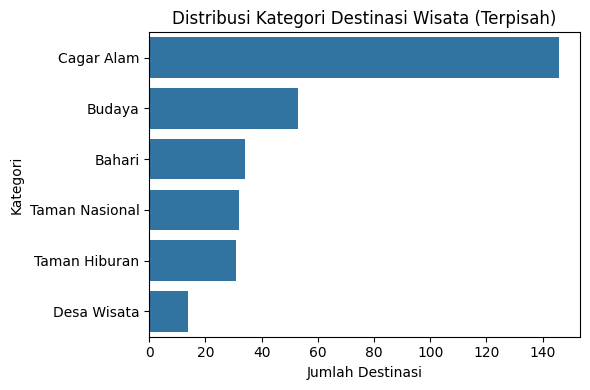

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=frekuensi_kategori.values, y=frekuensi_kategori.index)
plt.title('Distribusi Kategori Destinasi Wisata (Terpisah)')
plt.xlabel('Jumlah Destinasi')
plt.ylabel('Kategori')
plt.tight_layout()
plt.show()

**Insight:**

Kategori Cagar Alam merupakan yang paling dominan dalam dataset ini dengan 146 destinasi, disusul oleh Budaya, Bahari, dan Taman Nasional. Hal ini menunjukkan bahwa fokus utama ekowisata di Indonesia masih terpusat pada pelestarian alam dan budaya lokal.

### **3. Sebaran Destinasi Berdasarkan Kota**

Pada bagian ini dilakukan analisis terhadap kolom city untuk mengetahui jumlah kota atau kabupaten yang tercatat dalam dataset, serta menghitung jumlah destinasi wisata yang terdapat di masing-masing kota.

In [ ]:
jumlah_kota = df_place['city'].nunique()
print(f"Total Kota/Kabupaten Tercatat: {jumlah_kota}")

jumlah_destinasi_per_kota = df_place['city'].value_counts().sort_values(ascending=False)

print("\nJumlah Destinasi per Kota/Kabupaten:")
print(jumlah_destinasi_per_kota)

Total Kota/Kabupaten Tercatat: 47

Jumlah Destinasi per Kota/Kabupaten:
city
Yogyakarta          53
Bandung             36
Semarang            17
Jakarta             12
Bogor                7
Malang               5
Jambi                3
Surabaya             3
Bali                 3
Lampung              2
Manggarai            2
Kulon Progo          2
Lombok               2
Sukabumi             2
Aceh                 1
Jember               1
Gunungkidul          1
Ende                 1
Garut                1
Denpasar             1
Boyolali             1
Bantul               1
Banyuwangi           1
Banten               1
Kalimantan Timur     1
Kotawaringin         1
Magelang             1
Sumatera Barat       1
Kubu Raya            1
Jepara               1
Kapuas Hulu          1
Papua Barat          1
Palembang            1
Padang               1
Pacitan              1
Pontianak            1
Pekanbaru            1
Pesawaran            1
Pelalawan            1
Situbondo            1
Sam

**Insight:**

Hasilnya menunjukkan bahwa terdapat total 47 kota/kabupaten dengan destinasi wisata tercatat. Dari distribusi tersebut, kota Yogyakarta memiliki jumlah destinasi wisata terbanyak, yakni 53 lokasi, disusul oleh Bandung dengan 36 destinasi, serta Semarang dan Jakarta dengan 17 dan 12 destinasi masing-masing. Sementara itu, sebagian besar kota lainnya memiliki hanya 1–2 destinasi, menunjukkan adanya ketimpangan distribusi wisata antar kota dalam data yang tersedia.

#### **Visualisasi 10 Kota/Kabupaten dengan Jumlah Destinasi Wisata Terbanyak**

Visualisasi berikut menyajikan 10 kota/kabupaten dengan jumlah destinasi wisata terbanyak berdasarkan data yang tersedia. Visualisasi bar chart horizontal ini memberikan gambaran lebih jelas mengenai distribusi destinasi yang dominan di kota-kota tertentu.


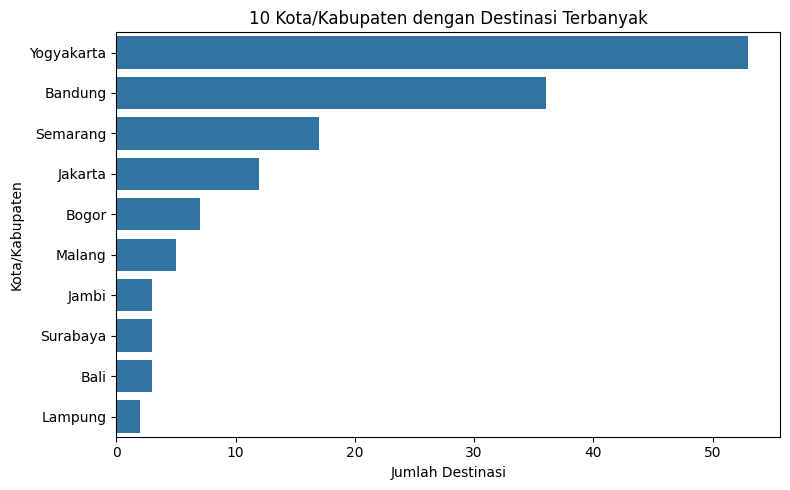

In [ ]:
top_kota = jumlah_destinasi_per_kota.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_kota.values, y=top_kota.index)
plt.title('10 Kota/Kabupaten dengan Destinasi Terbanyak', fontsize=12)
plt.xlabel('Jumlah Destinasi')
plt.ylabel('Kota/Kabupaten')
plt.tight_layout()
plt.show()

**Insight:**

Kota Yogyakarta dan Bandung menempati posisi teratas dengan jumlah destinasi wisata terbanyak, menunjukkan potensi wisata yang sangat kuat di kedua daerah tersebut. Dominasi kota-kota di Pulau Jawa dalam daftar ini mengindikasikan konsentrasi pengembangan dan dokumentasi wisata yang lebih tinggi di wilayah tersebut.

### **4. Interaksi Pengguna per Destinasi**

Untuk mengevaluasi destinasi wisata yang paling banyak berinteraksi dengan pengguna, dilakukan analisis terhadap jumlah rating yang diberikan per destinasi. Semakin tinggi jumlah rating yang diterima, semakin sering destinasi tersebut dilihat dan dinilai oleh pengguna.

Visualisasi berikut menampilkan 10 destinasi teratas dengan jumlah rating terbanyak, yang dapat memberikan gambaran mengenai popularitas dan tingkat keterlibatan pengguna terhadap destinasi tersebut.

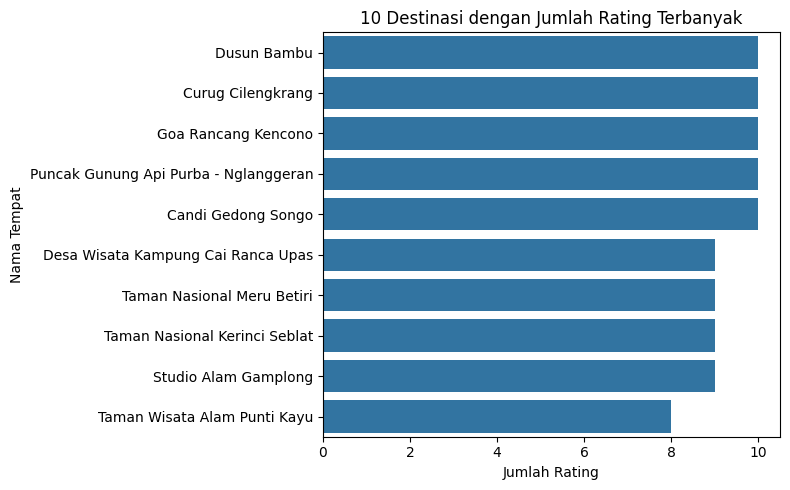

In [ ]:
top_rating_place = df_rating.groupby('place_id').size().reset_index(name='count')
top_rating_place = top_rating_place.sort_values(by='count', ascending=False).head(10)

top_rating_place = top_rating_place.merge(df_place[['place_id', 'place_name']], on='place_id')

plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='place_name', data=top_rating_place)
plt.title('10 Destinasi dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Nama Tempat')
plt.tight_layout()
plt.show()

**Insight:**

Destinasi seperti Dusun Bambu, Curug Cilengkrang, dan Goa Rancang Kencono termasuk yang paling sering dirating, menandakan popularitas atau keterlibatan pengguna yang tinggi terhadap destinasi ini.

### **5. Rata-rata Rating pada Destinasi Terpopuler**

Setelah mengetahui destinasi dengan jumlah interaksi terbanyak, langkah selanjutnya adalah menganalisis kualitas dari destinasi tersebut berdasarkan rata-rata rating yang diberikan pengguna. Rata-rata rating mencerminkan seberapa puas pengguna terhadap pengalaman mereka di destinasi tersebut.

Visualisasi berikut menunjukkan peringkat 10 destinasi paling populer berdasarkan nilai rata-rata rating yang diterima, membantu mengidentifikasi destinasi dengan performa terbaik dalam hal kualitas menurut pengguna.


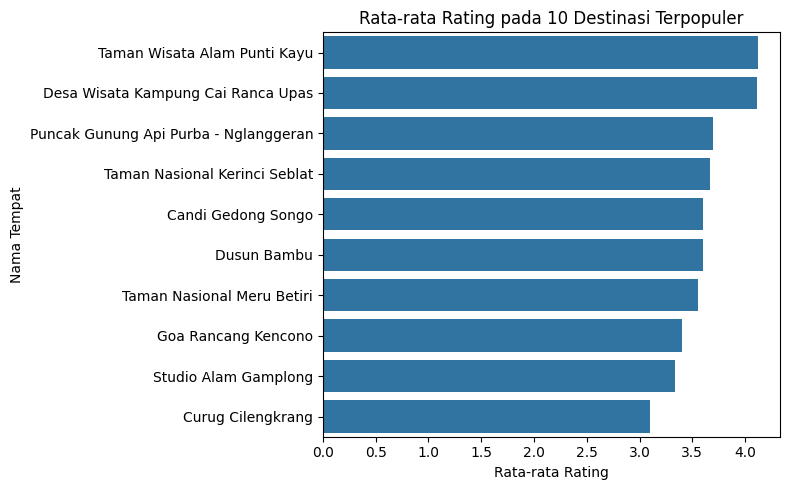

In [ ]:
avg_rating_top = df_rating[df_rating['place_id'].isin(top_rating_place['place_id'])]
avg_rating_top = avg_rating_top.groupby('place_id')['user_rating'].mean().reset_index(name='avg_rating')

avg_rating_top = avg_rating_top.merge(df_place[['place_id', 'place_name']], on='place_id')

avg_rating_top = avg_rating_top.sort_values(by='avg_rating', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='avg_rating', y='place_name', data=avg_rating_top)
plt.title('Rata-rata Rating pada 10 Destinasi Terpopuler')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Nama Tempat')
plt.tight_layout()
plt.show()

**Insight:**

Taman Wisata Alam Punti Kayu dan Kampung Cai Ranca Upas memiliki rata-rata rating tertinggi, menandakan kualitas pengalaman terbaik, sedangkan Curug Cilengkrang meski populer, memiliki rating terendah sehingga perlu evaluasi layanan.

### **6. Distribusi Nilai Rating dari Pengguna**

Distribusi nilai rating menggambarkan kecenderungan penilaian yang diberikan oleh pengguna terhadap destinasi wisata. Dengan melihat sebaran rating, kita dapat memahami persepsi umum pengguna terhadap kualitas pengalaman wisata secara keseluruhan.

Distribusi ini juga dapat menjadi indikator apakah sistem penilaian cenderung condong ke nilai tinggi (positif) atau terdapat persebaran yang seimbang di antara semua nilai.

In [ ]:
print(df_rating['user_rating'].value_counts().sort_index())

user_rating
2    140
3    273
4    301
5    135
Name: count, dtype: int64


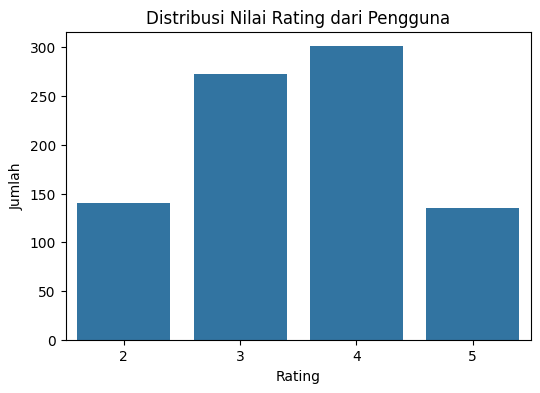

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='user_rating', data=df_rating)
plt.title('Distribusi Nilai Rating dari Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Insight:**

Sebagian besar pengguna memberikan rating 3 dan 4, masing-masing sebanyak 273 dan 301 kali. Rating 5 yang merupakan nilai tertinggi justru lebih sedikit (135 kali), hampir sama sedikitnya dengan rating 2 (140 kali).

# **Data Preparation**

### **Menggabungkan dataset rating dan data tempat wisata menggunakan place_id.**

Untuk membangun sistem rekomendasi yang efektif, kita perlu menggabungkan informasi interaksi pengguna (rating) dengan data tempat wisata. Penggabungan dilakukan berdasarkan place_id agar setiap baris menyimpan informasi lengkap tentang interaksi pengguna terhadap suatu destinasi.

In [ ]:
df = pd.merge(df_rating, df_place, on='place_id', how='inner')
print("Dataset berhasil digabungkan:", df.shape)

Dataset berhasil digabungkan: (846, 15)


#### **Selanjutnya, menampilkan data awal hasil penggabungan:**

In [ ]:
df.head()

,user_id,place_id,user_rating,place_name,place_description,category,city,price,rating,description_location,place_img,gallery_photo_img1,gallery_photo_img2,gallery_photo_img3,place_map
0,1,28,2,Saung Angklung Mang Udjo,Saung Angklung Mang Udjo adalah tempat wisata ...,Budaya,Bandung,"Rp75,000",4.7,"Jl. Padasuka No.118, Pasirlayung, Kec. Cibeuny...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Saung+Angkl...
1,1,86,4,Desa Wisata Ngadas,Desa ini terkenal karena keindahan alamnya yan...,"Cagar Alam,Desa Wisata",Malang,Gratis,4.5,"Ngadas, poncokusumo, Kabupaten Malang, Jawa Timur",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,NaN,https://www.google.com/maps/search/Desa+Wisata...
2,1,94,4,Taman Wisata Alam Punti Kayu,Taman Wisata Alam Punti Kayu terletak di Kota ...,"Budaya,Cagar Alam",Palembang,"Rp10,000",4.3,"Jalan Kol. Burlian Km. 6,5, Karya Baru, Alang ...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,NaN,https://www.google.com/maps/search/Taman+Wisat...
3,1,146,3,Hutan Pinus Pengger,Hutan Pinus Pengger mudah dijangkau karena ter...,"Cagar Alam,Taman Hiburan",Yogyakarta,"Rp3,000",4.5,"Jl. Dlingo-Patuk, Sendangsari, Terong, Kec. Dl...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,NaN,https://www.google.com/maps/search/Hutan+Pinus...
4,2,17,2,Gunung Lalakon,Gunung Lalakon adalah gunung yang terletak di ...,"Cagar Alam,Taman Nasional",Bandung,Gratis,4.8,"Situwangi, Cihampelas, West Bandung Regency, W...",https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://storage.googleapis.com/travelee-capsto...,https://www.google.com/maps/search/Gunung+Lalakon


**Insight:**

Dataset gabungan ini terdiri dari 846 baris dan 15 kolom, yang merepresentasikan interaksi pengguna terhadap berbagai destinasi wisata di Indonesia. Informasi ini mencakup nama tempat, kota, kategori, harga, rating pengguna, serta metadata lain seperti gambar dan peta lokasi.

### **Removing Duplicates**

Untuk memastikan setiap destinasi wisata hanya muncul satu kali dalam dataset, kita perlu menghapus baris duplikat berdasarkan kolom place_id.

In [ ]:
df.drop_duplicates(subset=['place_id'], inplace=True)

### **Handling Missing Value**

Langkah ini bertujuan untuk menghapus data yang memiliki nilai kosong (missing value), terutama pada kolom yang bersifat penting untuk proses analisis dan pemodelan.

In [ ]:
df.isnull().sum()

,0
user_id,0
place_id,0
user_rating,0
place_name,0
place_description,0
category,0
city,0
price,0
rating,0
description_location,0


**Insight:**

Dari hasil pemeriksaan, terlihat bahwa terdapat:

* 2 nilai kosong pada kolom gallery_photo_img2

* 77 nilai kosong pada kolom gallery_photo_img3


#### **Menghapus Baris dengan Nilai Kosong pada Gambar Galeri**

In [ ]:
df.dropna(subset=['gallery_photo_img2', 'gallery_photo_img3'], inplace=True)

df.isnull().sum()

,0
user_id,0
place_id,0
user_rating,0
place_name,0
place_description,0
category,0
city,0
price,0
rating,0
description_location,0


**Insight:**

Setelah penghapusan, semua kolom tidak memiliki missing value (0), artinya data sekarang bersih dari nilai kosong untuk kolom gambar galeri.



#### **Menghapus Baris Kosong pada Kolom Penting**

Sebagai langkah terakhir, kita memastikan tidak ada nilai kosong pada kolom-kolom penting yang digunakan dalam model, seperti ID pengguna, ID destinasi, rating, nama tempat, deskripsi, dan kategori.

In [ ]:
important_columns = ['user_id', 'place_id', 'user_rating', 'place_name', 'place_description', 'category']
df.dropna(subset=important_columns, inplace=True)

**Insight:**

Dengan penghapusan ini, kita memastikan hanya data yang lengkap dan relevan yang akan digunakan dalam proses pemodelan rekomendasi, meningkatkan kualitas hasil akhir.

### **Membersihkan format penulisan harga**

Langkah ini bertujuan untuk membersihkan format harga agar dapat diolah sebagai data numerik.

In [ ]:
df['price'] = df['price'].replace('-', '0')
df['price'] = df['price'].fillna('0')

df['price'] = df['price'].replace('[^0-9]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)

**Insight:**

* Semua data harga yang semula berupa string seperti "Rp25,000" telah dikonversi menjadi angka.
* Tanda strip (`-`) dan `NaN` yang sebelumnya mengindikasikan "gratis" atau tidak tersedia kini diubah menjadi nilai `0`.
* Kolom `price` kini bersih dan siap digunakan untuk analisis numerik atau pemodelan.

### **Menghapus kolom yang tidak relevan**

Menghapus kolom-kolom seperti gambar dan lokasi peta yang tidak berkontribusi langsung pada proses pemodelan sistem rekomendasi.

In [ ]:
columns_to_drop = [
    'place_img',
    'gallery_photo_img1',
    'gallery_photo_img2',
    'gallery_photo_img3',
    'place_map',
    'description_location',
]

df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
df.head()

,user_id,place_id,user_rating,place_name,place_description,category,city,price,rating
0,1,28,2,Saung Angklung Mang Udjo,Saung Angklung Mang Udjo adalah tempat wisata ...,Budaya,Bandung,75000.0,4.7
4,2,17,2,Gunung Lalakon,Gunung Lalakon adalah gunung yang terletak di ...,"Cagar Alam,Taman Nasional",Bandung,0.0,4.8
7,2,103,4,Air Terjun Semirang,Terletak di lereng Gunung Ungaran bagian utara...,Cagar Alam,Semarang,9000.0,4.4
12,3,73,3,Taman Nasional Betung Kerihun,Taman Nasional Betung Kerihun merupakan salah ...,"Cagar Alam,Taman Nasional",Kapuas Hulu,10000.0,4.4
13,3,92,4,Pantai Klayar,"Pantai ini terkenal dengan keindahan alamnya, ...","Bahari,Cagar Alam",Pacitan,10000.0,4.5


**Insight:**

Dengan menghapus kolom visual dan lokasi yang tidak relevan, dataset menjadi lebih sederhana dan terfokus pada fitur-fitur penting yang diperlukan untuk proses analisis dan pemodelan sistem rekomendasi. Ini juga membantu mengurangi noise.


### **Menampilkan dataset yang sudah dibersihkan**

In [ ]:
cleaned_data = df
cleaned_data

,user_id,place_id,user_rating,place_name,place_description,category,city,price,rating
0,1,28,2,Saung Angklung Mang Udjo,Saung Angklung Mang Udjo adalah tempat wisata ...,Budaya,Bandung,75000.0,4.7
4,2,17,2,Gunung Lalakon,Gunung Lalakon adalah gunung yang terletak di ...,"Cagar Alam,Taman Nasional",Bandung,0.0,4.8
7,2,103,4,Air Terjun Semirang,Terletak di lereng Gunung Ungaran bagian utara...,Cagar Alam,Semarang,9000.0,4.4
12,3,73,3,Taman Nasional Betung Kerihun,Taman Nasional Betung Kerihun merupakan salah ...,"Cagar Alam,Taman Nasional",Kapuas Hulu,10000.0,4.4
13,3,92,4,Pantai Klayar,"Pantai ini terkenal dengan keindahan alamnya, ...","Bahari,Cagar Alam",Pacitan,10000.0,4.5
...,...,...,...,...,...,...,...,...,...
504,91,99,4,Taman Wisata Alam Hutan Albasia,Taman Wisata Alam Kubu Raya adalah taman wisat...,"Budaya,Cagar Alam",Pontianak,5000.0,4.1
542,98,158,4,Pantai Jungwok,Pantai Jungwok adalah pantai yang terletak di ...,"Bahari,Cagar Alam",Yogyakarta,5000.0,4.6
575,104,36,3,Taman Hutan Raya Ir. H. Djuanda,Taman Hutan Raya Ir. H. Djuanda adalah taman k...,"Budaya,Taman Hiburan",Bandung,15000.0,4.6
600,108,157,5,Pantai Jogan,Pantai Jogan adalah objek wisata pantai yang t...,"Bahari,Cagar Alam",Yogyakarta,5000.0,4.4


**Insight:**

Dataset yang telah dibersihkan kini hanya terdiri dari kolom-kolom yang relevan untuk proses analisis dan pemodelan sistem rekomendasi, seperti `user_id`, `place_id`, `user_rating`, `place_name`, `place_description`, `category`, `city`, `price`, dan `rating`.
Jumlah data akhir adalah 104 baris × 9 kolom, yang berarti siap digunakan untuk tahap eksplorasi data atau membangun model rekomendasi.



### **Melakukan konversi data series menjadi list**

In [ ]:
list_place_id = df['place_id'].values.tolist()
list_place_name = df['place_name'].values.tolist()
list_user_id = df['user_id'].values.tolist()
list_user_rating = df['user_rating'].values.tolist()

print(f"Jumlah data place_id: {len(list_place_id)}")
print(f"Jumlah data place_name: {len(list_place_name)}")
print(f"Jumlah data user_id: {len(list_user_id)}")
print(f"Jumlah data user_rating: {len(list_user_rating)}")

Jumlah data place_id: 104
Jumlah data place_name: 104
Jumlah data user_id: 104
Jumlah data user_rating: 104


**Insight:**

Keempat list yang dibuat memiliki panjang yang sama, yaitu 104 elemen. Ini menunjukkan bahwa tidak ada data yang hilang atau tidak konsisten antara kolom-kolom tersebut. Data sudah siap digunakan untuk keperluan analisis lebih lanjut atau pembuatan sistem rekomendasi berbasis array/list.

### **Menyusun dictionary berisi informasi konten tiap tempat wisata**

In [ ]:
place_content_dict = {
    'place_id': df['place_id'].astype(str).tolist(),
    'place_name': df['place_name'].astype(str).tolist(),
    'place_description': df['place_description'].astype(str).tolist(),
    'category': df['category'].astype(str).tolist(),
    'city': df['city'].astype(str).tolist()
}

place_content_df = pd.DataFrame(place_content_dict)

print("Data konten tempat wisata berhasil dibuat.")
place_content_df.head()

Data konten tempat wisata berhasil dibuat.


,place_id,place_name,place_description,category,city
0,28,Saung Angklung Mang Udjo,Saung Angklung Mang Udjo adalah tempat wisata ...,Budaya,Bandung
1,17,Gunung Lalakon,Gunung Lalakon adalah gunung yang terletak di ...,"Cagar Alam,Taman Nasional",Bandung
2,103,Air Terjun Semirang,Terletak di lereng Gunung Ungaran bagian utara...,Cagar Alam,Semarang
3,73,Taman Nasional Betung Kerihun,Taman Nasional Betung Kerihun merupakan salah ...,"Cagar Alam,Taman Nasional",Kapuas Hulu
4,92,Pantai Klayar,"Pantai ini terkenal dengan keindahan alamnya, ...","Bahari,Cagar Alam",Pacitan


**Insight:**

Lima kolom teks yaitu place_id, place_name, place_description, category, dan city dipilih sebagai fitur utama untuk sistem content-based filtering. Kolom-kolom ini menggambarkan ragam destinasi ekowisata dengan berbagai kategori dan lokasi, serta dilengkapi deskripsi yang informatif. Informasi ini memberikan dasar yang kuat untuk mengidentifikasi kemiripan antar tempat dan menghasilkan rekomendasi yang lebih relevan.

# **Model Development Dengan Content Based Filtering**

### **Melakukan Assign DataFrame ke Variabel Baru**

In [ ]:
content_features_df = place_content_df

**Insight:**

Langkah ini bertujuan untuk menyalin isi dari `place_content_df` ke variabel baru `content_features_df`, yang akan digunakan khusus untuk proses ekstraksi fitur dan perhitungan kemiripan dalam model Content-Based Filtering.


### **Merancang sistem rekomendasi dengan ekstraksi fitur TF-IDF**

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(content_features_df['category'])
tfidf_features = vectorizer.get_feature_names_out()

print(f"Total fitur yang diekstraksi: {len(tfidf_features)}")
print("\nFitur hasil ekstraksi dari TF-IDF:")
for i, feature in enumerate(tfidf_features, start=1):
    print(f"{i}. {feature}")

Total fitur yang diekstraksi: 9

Fitur hasil ekstraksi dari TF-IDF:
1. alam
2. bahari
3. budaya
4. cagar
5. desa
6. hiburan
7. nasional
8. taman
9. wisata


**Insight:**

Dari kolom `category`, TF-IDF berhasil mengekstraksi 9 fitur unik yang merepresentasikan kategori tempat wisata dalam bentuk token kata. Fitur-fitur ini mencakup aspek seperti "alam", "budaya", "taman", "bahari", dan lainnya. Ini menjadi dasar untuk mengukur kemiripan antar tempat wisata berdasarkan kategorinya menggunakan pendekatan Content-Based Filtering.

### **Membangun representasi matriks berdasarkan bobot TF-IDF dari data kategori**

In [ ]:
tfidf_matrix = vectorizer.transform(content_features_df['category'])
print(f"Dimensi hasil representasi TF-IDF: {tfidf_matrix.shape}")

Dimensi hasil representasi TF-IDF: (104, 9)


**Insight:**

Output menunjukkan bahwa hasil transformasi TF-IDF menghasilkan matriks berdimensi (104, 9), artinya terdapat 104 tempat wisata (baris) dan 9 fitur (kolom) hasil ekstraksi dari kategori. Setiap tempat wisata kini direpresentasikan sebagai vektor numerik berdasarkan bobot kata-kata kategorinya, yang akan digunakan untuk menghitung kemiripan antar tempat.

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.328567  , 0.        , 0.        , 0.328567  , 0.        ,
         0.        , 0.67158843, 0.57711041, 0.        ],
        [0.70710678, 0.        , 0.        , 0.70710678, 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.328567  , 0.        , 0.        , 0.328567  , 0.        ,
         0.        , 0.67158843, 0.57711041, 0.        ],
        [0.37254367, 0.84995436, 0.        , 0.37254367, 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.70710678, 0.        , 0.        , 0.70710678, 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.70710678, 0.        , 0.        , 0.70710678, 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.29774514, 0.        , 0.        , 0.29774514, 0.        ,
         0.74107652, 0.        , 0.5229734

**Insight:**

Output tfidf_matrix.todense() diatas adalah representasi dense matrix dari hasil transformasi TF-IDF terhadap data teks yang dimiliki. Masing-masing baris merepresentasikan sebuah dokumen, dan masing-masing kolom mewakili satu fitur kata (term) dalam korpus setelah tokenisasi dan filtering oleh TfidfVectorizer.


### **Konversi Matriks TF-IDF ke Dalam Bentuk DataFrame**

Setelah menghitung representasi TF-IDF dari data teks (fitur kategori destinasi), langkah selanjutnya adalah mengonversi hasil tersebut dari bentuk sparse matrix ke dalam dense matrix agar lebih mudah dianalisis dan divisualisasikan.

In [ ]:
df_vector_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=content_features_df['category']
)

tfidf_sample = df_vector_tfidf.sample(n=10, axis=0).sample(n=9, axis=1)

tfidf_sample

,hiburan,bahari,alam,wisata,taman,desa,cagar,budaya,nasional
category,,,,,,,,,
Cagar Alam,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.000000,0.0
Budaya,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
"Budaya,Cagar Alam",0.000000,0.000000,0.443455,0.000000,0.000000,0.000000,0.443455,0.778906,0.0
Cagar Alam,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.000000,0.0
"Cagar Alam,Taman Hiburan",0.741077,0.000000,0.297745,0.000000,0.522973,0.000000,0.297745,0.000000,0.0
"Bahari,Cagar Alam",0.000000,0.849954,0.372544,0.000000,0.000000,0.000000,0.372544,0.000000,0.0
"Budaya,Cagar Alam",0.000000,0.000000,0.443455,0.000000,0.000000,0.000000,0.443455,0.778906,0.0
"Cagar Alam,Taman Hiburan",0.741077,0.000000,0.297745,0.000000,0.522973,0.000000,0.297745,0.000000,0.0
"Desa Wisata,Taman Hiburan",0.492237,0.000000,0.000000,0.564374,0.347369,0.564374,0.000000,0.000000,0.0


**Insight:**

1. Nilai TF-IDF menunjukkan relevansi kata dalam kategori tertentu:

   * Misalnya, baris `Budaya,Cagar Alam` memiliki nilai tinggi pada kolom `budaya` dan `cagar`, masing-masing sebesar `0.778906` dan `0.443455`. Ini menunjukkan bahwa kata "budaya" sangat representatif terhadap kategori tersebut.
   * Baris `Bahari,Cagar Alam` memiliki nilai TF-IDF tertinggi pada kata "bahari"**, yaitu `0.849954`, mengindikasikan bahwa "bahari" merupakan kata yang paling membedakan dokumen tersebut dari yang lain.

2. Nilai 0 mengindikasikan ketidakhadiran atau ketidakpentingan kata:

   * Kolom dengan nilai 0 menunjukkan bahwa kata tersebut tidak muncul atau tidak penting dalam dokumen/kategori tersebut berdasarkan bobot TF-IDF.
   * Misalnya, pada baris `Budaya`, semua nilai selain `budaya` adalah 0. Ini mengindikasikan bahwa hanya kata *budaya* yang penting dan muncul pada kategori tersebut.

3. Kombinasi kategori memengaruhi bobot TF-IDF:

   * Misalnya, `Cagar Alam,Taman Hiburan` memiliki nilai tinggi di kata "hiburan", "taman", dan "cagar". Ini menunjukkan bahwa ketiga kata tersebut relevan dalam kombinasi tersebut, yang membantu sistem dalam mengenali karakteristik uniknya saat digunakan dalam sistem rekomendasi.

4. Distribusi term antar kategori membantu dalam proses Content-Based Filtering:

   * Vektor-vektor ini nantinya digunakan untuk menghitung cosine similarity antar kategori, sehingga sistem rekomendasi dapat menyarankan destinasi dengan kemiripan konten yang tinggi.

### **Perhitungan Cosine Similarity Antar Destinasi Ekowisata**

Tahapan ini dilakukan untuk menghitung tingkat kemiripan antar destinasi berdasarkan vektor TF-IDF yang sudah terbentuk dari data kategorikal.

In [ ]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=content_features_df['place_name'],
    columns=content_features_df['place_name']
)

print("Contoh cuplikan dari matriks kesamaan antar destinasi ekowisata:")
preview_similarity = similarity_df.sample(n=5, axis=0).sample(n=5, axis=1)
preview_similarity

Contoh cuplikan dari matriks kesamaan antar destinasi ekowisata:


place_name,Pantai Sadranan,Taman Nasional Gunung Rinjani,Pantai Wediombo,Watu Gunung Ungaran,Pantai Ngrenehan
place_name,,,,,
Sendang Geulis Kahuripan,0.330413,0.291410,0.330413,0.627141,0.330413
Desa Wisata Nglanggeran,0.000000,0.000000,0.000000,0.000000,0.000000
Kebun Bibit Wonorejo,0.526856,0.464664,0.526856,1.000000,0.526856
Taman Wisata Alam Situgunung,0.330413,0.291410,0.330413,0.627141,0.330413
Pantai Jogan,1.000000,0.244811,1.000000,0.526856,1.000000


**Insight:**

1. Nilai Similarity Berkisar antara 0 sampai 1:

   * Nilai 1.0 menunjukkan bahwa dua destinasi sangat mirip atau identik dalam representasi kontennya (seperti `Pantai Jogan` dengan dirinya sendiri).
   * Nilai mendekati 0 mengindikasikan hampir tidak ada kesamaan konten antar dua destinasi, contohnya `Desa Wisata Nglanggeran` dengan semua destinasi lainnya (semuanya 0.000000).

2. Korelasi Kemiripan antara Lokasi Serupa:

   * `Kebun Bibit Wonorejo` memiliki tingkat kemiripan tinggi dengan `Pantai Wediombo` (0.526856) dan `Watu Gunung Ungaran` (1.000000), yang menunjukkan bahwa mereka mungkin memiliki kategori konten yang sama atau sangat mirip.
   * `Sendang Geulis Kahuripan` dan `Taman Wisata Alam Situgunung` juga memiliki nilai similarity yang identik terhadap beberapa tempat lain, mengindikasikan kemiripan kategori.

3. Manfaat untuk Sistem Rekomendasi:

   * Matriks ini akan digunakan dalam sistem Content-Based Filtering, di mana destinasi dengan similarity tertinggi terhadap destinasi yang sedang dilihat pengguna akan direkomendasikan sebagai alternatif yang relevan.



### **Merancang fungsi model rekomendasi**

In [ ]:
class DestinationRecommender:
    def __init__(self, similarity_matrix, content_features_df):
        self.similarity_df = similarity_matrix
        self.place_content_df = content_features_df

    def recommend_by_category_city(self, selected_category, selected_city=None, top_n=5, same_city_only=False):
        filtered_df = self.place_content_df[
            self.place_content_df['category'].str.contains(selected_category, case=False, na=False)
        ]

        if selected_city:
            if same_city_only:
                filtered_df = filtered_df[filtered_df['city'].str.lower() == selected_city.lower()]

        if filtered_df.empty:
            raise ValueError("Tidak ditemukan destinasi yang sesuai dengan kategori dan/atau kota yang dimasukkan.")

        similarity_scores = {}
        for place in filtered_df['place_name']:
            if place in self.similarity_df.columns:
                similar_places = self.similarity_df[place]
                score = similar_places[filtered_df['place_name']].sum()
                similarity_scores[place] = score

        sorted_places = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
        top_places = [place for place, score in sorted_places[:top_n]]

        rekomendasi_df = filtered_df[filtered_df['place_name'].isin(top_places)][['place_name', 'category', 'city']]
        rekomendasi_df = rekomendasi_df.drop_duplicates(subset='place_name').reset_index(drop=True)

        return rekomendasi_df

recommender = DestinationRecommender(similarity_df, place_content_df)

**Insight:**

Pada tahap diatas, dibuat sebuah class DestinationRecommender yang bertujuan untuk merekomendasikan destinasi wisata berbasis kategori dan kota. Fungsi ini memanfaatkan matriks kesamaan (cosine similarity) antar destinasi dan fitur konten dari masing-masing tempat.

### **Penggunaan dari sistem rekomendasi**

Kode berikut menunjukkan bagaimana pengguna dapat berinteraksi secara langsung dengan sistem rekomendasi melalui input terminal. Sistem akan meminta pengguna untuk memasukkan kategori dan kota (opsional), lalu memberikan hasil rekomendasi destinasi ekowisata berdasarkan input tersebut.

In [ ]:
while True:
    kategori = input("Masukkan kategori wisata (contoh: budaya, cagar alam): ")
    kota = input("Masukkan nama kota (opsional, tekan Enter jika ingin semua kota): ")
    same_city_pref = input("Apakah Anda hanya ingin rekomendasi dari kota yang sama? (y/n): ").strip().lower()
    same_city_only = True if same_city_pref == 'y' else False

    try:
        rekomendasi = recommender.recommend_by_category_city(
            selected_category=kategori,
            selected_city=kota if kota else None,
            top_n=5,
            same_city_only=same_city_only
        )

        if not rekomendasi.empty:
            print("\n🎯 Rekomendasi Destinasi Wisata:\n")
            print(tabulate(
                rekomendasi.reset_index(drop=True),
                headers="keys",
                tablefmt="grid",
                showindex=True
            ))
        else:
            print("\nTidak ada destinasi yang direkomendasikan.")

    except ValueError as e:
        print(f"\n[!] {e}")

    ulang = input("\nIngin mencari rekomendasi lagi? (y/n): ").strip().lower()
    if ulang != 'y':
        break

Masukkan kategori wisata (contoh: budaya, cagar alam): budaya
Masukkan nama kota (opsional, tekan Enter jika ingin semua kota): bandung
Apakah Anda hanya ingin rekomendasi dari kota yang sama? (y/n): y

🎯 Rekomendasi Destinasi Wisata:

+----+------------------------------+-------------------+---------+
|    | place_name                   | category          | city    |
+====+==============================+===================+=========+
|  0 | Stone Garden Citatah         | Budaya,Cagar Alam | Bandung |
+----+------------------------------+-------------------+---------+
|  1 | Taman Wisata Alam Cikole     | Budaya,Cagar Alam | Bandung |
+----+------------------------------+-------------------+---------+
|  2 | Taman Kupu-Kupu Cihanjuang   | Budaya,Cagar Alam | Bandung |
+----+------------------------------+-------------------+---------+
|  3 | Gua Pawon                    | Budaya,Cagar Alam | Bandung |
+----+------------------------------+-------------------+---------+
|  4 | Taman Wis

**Insight dari Output Sistem Rekomendasi**

1. Pencarian 1:

   * Input: Kategori = `budaya`, Kota = `bandung`, Hanya dari kota yang sama = `ya`
   * Hasil: Sistem menampilkan 5 destinasi budaya yang berada di kota Bandung.
   * Sistem berhasil menampilkan tempat wisata yang sesuai dengan kategori dan kota yang diminta.

2. Pencarian 2:

   * Input: Kategori = `cagar alam`, Kota = `yogyakarta`, Hanya dari kota yang sama = `ya`
   * Hasil: Rekomendasi berisi pantai-pantai di Yogyakarta yang masuk kategori `"Bahari, Cagar Alam"`.
   * Sistem bisa menampilkan tempat dengan kategori gabungan asalkan mengandung kata "cagar alam", dan hanya dari kota yang diminta.

3. Pencarian 3:

   * Input: Kategori = `cagar alam`, Kota tidak diisi, Hanya dari kota yang sama = `tidak`
   * Hasil: Sistem merekomendasikan tempat dari berbagai kota (Semarang dan Bandung) yang sesuai kategori.
   * Jika kota tidak diisi, sistem memberikan rekomendasi dari kota mana saja yang paling relevan dengan kategori.


# **Model Development dengan Collaborative Filtering**

### **Menyimpan dataset rating ke variabel rating_df**

In [ ]:
ratings_df = df_rating
ratings_df

,user_id,place_id,user_rating
0,1,28,2
1,1,86,4
2,1,94,4
3,1,146,3
4,2,17,2
...,...,...,...
844,156,144,4
845,156,15,5
846,156,29,4
847,156,52,4


**Insight:**

* Dataset berisi 849 interaksi antara pengguna (`user_id`) dan destinasi (`place_id`).
* Setiap baris menunjukkan rating yang diberikan pengguna terhadap suatu destinasi wisata.

### **Melakukan encoding pada user_id dan place_id**

In [ ]:
encoded_ratings = ratings_df.copy()

user_id_encoder = LabelEncoder()
place_id_encoder = LabelEncoder()

encoded_ratings['encoded_user'] = user_id_encoder.fit_transform(encoded_ratings['user_id'])
encoded_ratings['encoded_place'] = place_id_encoder.fit_transform(encoded_ratings['place_id'])

print("Contoh hasil encoding user_id dan place_id:")
display(encoded_ratings[['user_id', 'encoded_user']].drop_duplicates().head())
display(encoded_ratings[['place_id', 'encoded_place']].drop_duplicates().head())

Contoh hasil encoding user_id dan place_id:


,user_id,encoded_user
0,1,0
4,2,1
11,3,2
18,4,3
22,5,4


,place_id,encoded_place
0,28,26
1,86,84
2,94,92
3,146,144
4,17,15


**Insight:**

* Encoding mengubah `user_id` dan `place_id` ke bentuk numerik berurutan agar bisa digunakan dalam model Machine Learning.
* Contoh: `user_id` 1 menjadi `encoded_user` 0, `place_id` 28 menjadi `encoded_place` 26.
* Proses ini penting agar algoritma seperti Matrix Factorization bisa memahami data.

### **Mengecek Jumlah Entitas & Rentang Rating**

In [ ]:
total_pengguna_unik = ratings_df['user_id'].nunique()
total_destinasi_unik = ratings_df['place_id'].nunique()

batas_bawah_rating = ratings_df['user_rating'].min()
batas_atas_rating = ratings_df['user_rating'].max()

print("Informasi Ringkas Dataset 'ratings.csv'")
print("=" * 45)
print(f"Jumlah unik pengguna        : {total_pengguna_unik}")
print(f"Jumlah unik destinasi       : {total_destinasi_unik}")
print(f"Nilai rating paling rendah  : {batas_bawah_rating}")
print(f"Nilai rating paling tinggi  : {batas_atas_rating}")

Informasi Ringkas Dataset 'ratings.csv'
Jumlah unik pengguna        : 156
Jumlah unik destinasi       : 182
Nilai rating paling rendah  : 2
Nilai rating paling tinggi  : 5


**Insight:**

* Dataset terdiri dari 156 pengguna unik dan 182 destinasi wisata unik.

* Rentang rating berada di antara 2 hingga 5. Artinya, tidak ada rating 1, sehingga semua rating cenderung ke arah positif. Hal ini perlu diperhatikan dalam evaluasi model nanti.

###  **Gabung Fitur, Normalisasi Rating, Split Data**

In [ ]:
x_values = encoded_ratings[['encoded_user', 'encoded_place']].to_numpy()

min_score = encoded_ratings['user_rating'].min()
max_score = encoded_ratings['user_rating'].max()

y_values = (encoded_ratings['user_rating'] - min_score) / (max_score - min_score)
y_values = y_values.to_numpy()

split_index = int(0.8 * len(encoded_ratings))

x_train = x_values[:split_index]
x_valid = x_values[split_index:]

y_train = y_values[:split_index]
y_valid = y_values[split_index:]

print("Contoh data fitur (x_train):")
print(x_train[:5])

print("\nContoh data label terstandarisasi (y_train):")
print(y_train[:5])

Contoh data fitur (x_train):
[[  0  26]
 [  0  84]
 [  0  92]
 [  0 144]
 [  1  15]]

Contoh data label terstandarisasi (y_train):
[0.         0.66666667 0.66666667 0.33333333 0.        ]


**Insight:**

* Data fitur terdiri dari pasangan (user, destinasi) yang telah diencode dalam bentuk numerik.

* Nilai rating dinormalisasi ke skala 0–1 untuk mempercepat dan menstabilkan proses training.

* Dataset dibagi menjadi 80% data latih dan 20% data validasi.

### **Merancang Fungsi Rekomendasi (Matrix Factorization)**

In [ ]:
class MatrixFactorizationRecommender:
    def __init__(self, num_users, num_places, embedding_size=50, learning_rate=0.001):
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        input_pair = tf.keras.Input(shape=(2,))

        user_input = layers.Lambda(lambda x: x[:, 0])(input_pair)
        user_embedding = layers.Embedding(
            input_dim=self.num_users,
            output_dim=self.embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )(user_input)

        place_input = layers.Lambda(lambda x: x[:, 1])(input_pair)
        place_embedding = layers.Embedding(
            input_dim=self.num_places,
            output_dim=self.embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )(place_input)

        similarity_score = layers.Dot(axes=1)([user_embedding, place_embedding])

        model = tf.keras.Model(inputs=input_pair, outputs=similarity_score)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model

    def train(self, x_train, y_train, x_val, y_val, epochs=20, batch_size=64):
        return self.model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def predict(self, x_input):
        return self.model.predict(x_input)

**Insight:**

* Model ini menggunakan pendekatan Matrix Factorization berbasis embedding layer untuk mempelajari hubungan laten antara user dan destinasi.

* Kombinasi user dan destinasi dihitung menggunakan dot product dari embedding masing-masing.

* Model dioptimasi dengan Adam Optimizer, menggunakan loss MSE (Mean Squared Error) dan metrik MAE (Mean Absolute Error).

* Disediakan method train() untuk pelatihan dan predict() untuk prediksi skor preferensi.


### **Inisialisasi dan Training**

In [ ]:
user_total = encoded_ratings['encoded_user'].nunique()
place_total = encoded_ratings['encoded_place'].nunique()

rekomendasi_model = MatrixFactorizationRecommender(
    num_users=user_total,
    num_places=place_total,
    embedding_size=50
)

training_log = rekomendasi_model.train(
    x_train, y_train,
    x_valid, y_valid,
    epochs=20,
    batch_size=64
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.3576 - mae: 0.5128 - val_loss: 0.3720 - val_mae: 0.5152
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3328 - mae: 0.4914 - val_loss: 0.3714 - val_mae: 0.5150
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3221 - mae: 0.4805 - val_loss: 0.3708 - val_mae: 0.5146
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3113 - mae: 0.4753 - val_loss: 0.3702 - val_mae: 0.5143
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2884 - mae: 0.4530 - val_loss: 0.3697 - val_mae: 0.5141
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2712 - mae: 0.4358 - val_loss: 0.3692 - val_mae: 0.5138
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2642 - mae: 0.4317 - val_loss: 0.3688 - val_mae: 0.5136
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2521 - mae: 0.4239 - val_loss: 0.3682 - val_mae: 0.5133
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2269

**Insight:**

* Model dilatih selama 20 epoch, dengan hasil loss dan MAE yang stabil menurun pada data training dan validasi.

* Val_loss turun dari 0.3720 → 0.3649, menunjukkan bahwa model makin baik dalam memprediksi rating destinasi.

* MAE validasi stabil di sekitar 0.511, menandakan konsistensi performa prediktif terhadap data baru.

* Proses ini berhasil melatih model untuk memahami preferensi pengguna berdasarkan pola interaksi historis.

### **Visualisasi Grafik Proses Training**

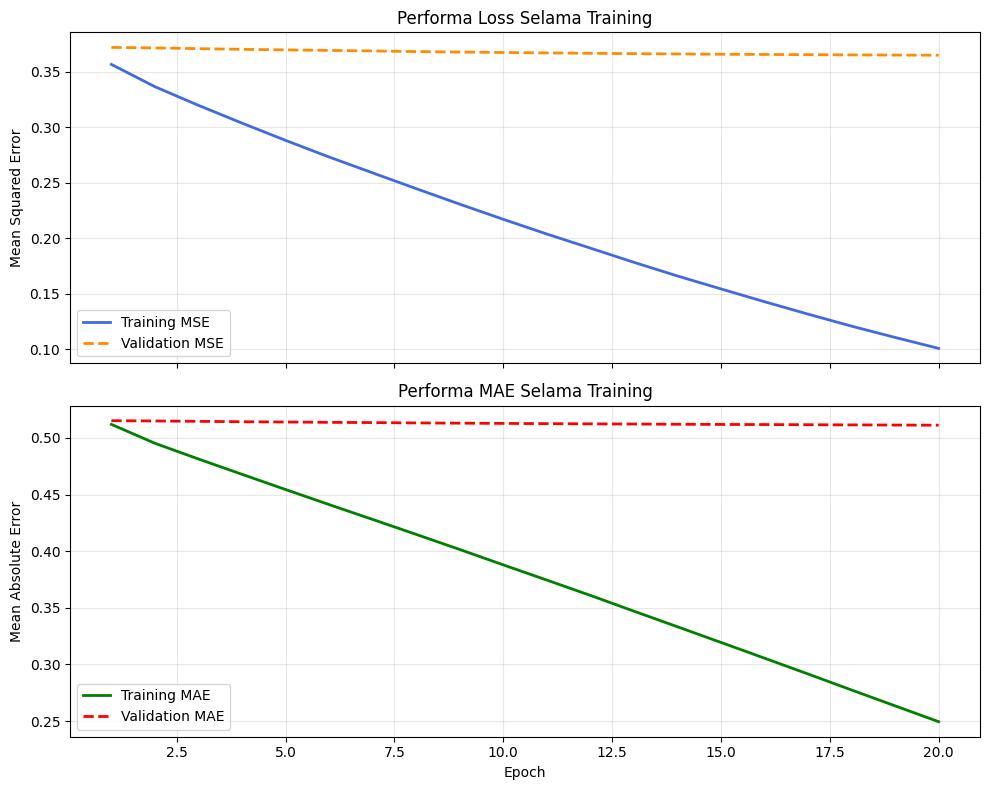

In [ ]:
def tampilkan_grafik_training(log_histori):
    epoch_range = range(1, len(log_histori.history['loss']) + 1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax[0].plot(epoch_range, log_histori.history['loss'], color='royalblue', linewidth=2, label='Training MSE')
    ax[0].plot(epoch_range, log_histori.history['val_loss'], color='darkorange', linestyle='--', linewidth=2, label='Validation MSE')
    ax[0].set_ylabel('Mean Squared Error')
    ax[0].set_title('Performa Loss Selama Training')
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    ax[1].plot(epoch_range, log_histori.history['mae'], color='green', linewidth=2, label='Training MAE')
    ax[1].plot(epoch_range, log_histori.history['val_mae'], color='red', linestyle='--', linewidth=2, label='Validation MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].set_title('Performa MAE Selama Training')
    ax[1].legend()
    ax[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

tampilkan_grafik_training(training_log)

**Insight dari Grafik Proses Training**

1. **Training MSE**
   - Nilai MSE pada data pelatihan menurun secara konsisten dari sekitar 0.36 ke 0.10 selama proses pelatihan.
   - Ini menunjukkan bahwa model berhasil mempelajari pola pada data training dengan baik.

2. **Validation MSE**
   - Garis MSE validasi relatif datar di sekitar 0.36 dan tidak menunjukkan penurunan berarti.
   - Ini bisa menjadi indikasi awal bahwa model tidak mengalami peningkatan performa terhadap data yang tidak dilihat sebelumnya (validasi).

3. **Training MAE**
   - MAE pada data pelatihan menurun dari sekitar 0.51 menjadi 0.24, yang menunjukkan peningkatan akurasi prediksi pada data training.

4. **Validation MAE**
   - Nilai MAE validasi tetap berada di kisaran 0.51 sepanjang proses pelatihan.
   - Hal ini memperkuat indikasi overfitting, di mana model terlalu fokus pada data pelatihan dan kurang mampu mengeneralisasi ke data baru.




### **Mendapatkan Tempat Yang Belum direview oleh User Tertentu**

In [ ]:
place_data = cleaned_data.copy()
rating_data = pd.read_csv('ratings.csv')

encoded_place_map = dict(zip(encoded_ratings['place_id'], encoded_ratings['encoded_place']))
encoded_user_map = dict(zip(encoded_ratings['user_id'], encoded_ratings['encoded_user']))


selected_user = rating_data['user_id'].sample(1).values[0]
rated_places = rating_data[rating_data['user_id'] == selected_user]['place_id'].tolist()

unrated_places = place_data[~place_data['place_id'].isin(rated_places)]['place_id'].tolist()
valid_unrated_places = [pid for pid in unrated_places if pid in encoded_place_map]

encoded_places = [[encoded_place_map[pid]] for pid in valid_unrated_places]
encoded_user_id = encoded_user_map.get(selected_user)

input_for_prediction = np.hstack((
    np.full((len(encoded_places), 1), encoded_user_id),
    encoded_places
))

**Insight:**

Kode di atas menyiapkan input prediksi berupa kombinasi antara user yang dipilih secara acak dan daftar tempat yang belum pernah ia rating, agar model bisa merekomendasikan tempat baru secara personal.

### **Rekomendasi Lokasi Wisata Terbaik Berdasarkan Preferensi User**

In [ ]:
import random

user_rating_counts = rating_data['user_id'].value_counts()
users_with_5_ratings = user_rating_counts[user_rating_counts == 5].index.tolist()

selected_user = random.choice(users_with_5_ratings)

user_rated_data = pd.merge(
    rating_data,
    place_data,
    on='place_id',
    how='inner'
)

user_rated_data.rename(columns={'user_rating_x': 'user_rating'}, inplace=True)

user_rated_data = user_rated_data[user_rated_data['user_id_x'] == selected_user]

top_5_favorit = user_rated_data.sort_values(by='user_rating', ascending=False).head(5)

print(f"5 Tempat Favorit dari User ID: {selected_user}")
print("=" * 60)
for idx, row in top_5_favorit.iterrows():
    print(f"{row['place_name']}")

rated_places = user_rated_data['place_id'].tolist()
unrated_places = place_data[~place_data['place_id'].isin(rated_places)]['place_id'].tolist()

valid_unrated_places = [pid for pid in unrated_places if pid in encoded_place_map]
encoded_places = [[encoded_place_map[pid]] for pid in valid_unrated_places]
encoded_user_id = encoded_user_map.get(selected_user)

input_for_prediction = np.hstack((
    np.full((len(encoded_places), 1), encoded_user_id),
    encoded_places
))

predicted_scores = rekomendasi_model.predict(input_for_prediction).flatten()

rekomendasi_df = pd.DataFrame({
    'place_id': valid_unrated_places,
    'predicted_score': predicted_scores
})

rekomendasi_df = rekomendasi_df.merge(place_data, on='place_id')
top_10_rekomendasi = rekomendasi_df.sort_values(by='predicted_score', ascending=False).head(10)

print("\n10 Rekomendasi Tempat Wisata untuk User ID:", selected_user)
print("=" * 60)
for idx, row in top_10_rekomendasi.iterrows():
    print(f"{row['place_name']}")

5 Tempat Favorit dari User ID: 129
Taman Hutan Raya Ir. H. Djuanda
Air Terjun Semirang
Taman Wisata Alam Ranca Upas
Taman Nasional Karimunjawa
Pantai Klayar
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

10 Rekomendasi Tempat Wisata untuk User ID: 129
Kawah Rengganis Cibuni
Kebun Bibit Wonorejo
Taman Wisata Alam Ciloto
Taman Wisata Alam Gunung Geulis
Taman Nasional Bromo Tengger Semeru
Desa Wisata Munduk
Kampoeng Kopi Banaran
Taman Nasional Bali Barat
Taman Nasional Berbak
Desa Wisata Cinangneng


**Insight Output Rekomendasi**

**1. Preferensi User:**

User ID 129 menunjukkan ketertarikan pada alam dan wisata terbuka seperti taman nasional, air terjun, dan hutan raya. Ini terlihat dari 5 tempat favoritnya:

* Taman Hutan Raya Ir. H. Djuanda
* Air Terjun Semirang
* Taman Wisata Alam Ranca Upas
* Taman Nasional Karimunjawa
* Pantai Klayar

**2. Rekomendasi Sistem:**

Model memberikan 10 destinasi yang belum dikunjungi, namun sangat relevan dengan pola minat user. Semua lokasi memiliki karakteristik serupa, seperti:

* Wisata alam dan taman nasional: Kawah Rengganis Cibuni, Taman Nasional Bromo Tengger Semeru, Taman Nasional Bali Barat
* Desa wisata dan edukasi alam: Desa Wisata Munduk, Desa Wisata Cinangneng, Kebun Bibit Wonorejo
* Lokasi dengan nuansa sejuk dan hijau: Kampoeng Kopi Banaran, Taman Wisata Alam Ciloto
